# Loss function Rodrigues

$𝒟 = \{ \mathbf{x}_n, \mathbf{y}_n\}$ be a dataset of size $N$

$\mathbf{x}_n \in \mathbb{R}^D$

${\mathbf{y}}^r_n\in[0,1]^K$:   label provided for the r-th annotator in a set of R annotators

$𝒛_n$ Latent true class determined by a softmax output layer  of a DNN


$\mathbf{\sigma}\in \mathbb{R} ^Q$: DNN-based feature representation. correspond to the output of a softmax layer

$\hat{\mathbf{y}}^r_n = f_r(\sigma)\in[0,1]^{1 \times K}$

$\hat{\mathbf{y}}_n=[\hat{\mathbf{y}}^1_n,\hat{\mathbf{y}}^2_n,\dots,\hat{\mathbf{y}}^R_n]\in [0,1]^{1\times (R\times K)}$

Activation of the crowd layer for each anotator  $ \mathbf{a}^r = f_r(\sigma)$, where $f_r$ is an annotator-specific function, and the output of the crowd layer simply as the softmax of the
activations $o_c^r = e^{a_c^r}/\sum_{l=1}^{C}e^{a_l^r}$.


 $f_r(\sigma)= \mathbf{W}^r\mathbf{\sigma}$

 $\mathbf{W}^r$ is an annotator-specific matrix

 **Cost function**

 $E(\mathbf{o}^r, y^r)$
 between the expected output of the r-th annotator and its actual label $y^r$,

Then, 

if we make. $\lambda_n^r(\theta) = \mathbf{1}$ in PRI loss



$$\min_\theta \sum_n\left(\sum_r \lambda_n^r(\theta)H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\lambda_n^r(\theta)\right)\right)$$

 
we can obtain rodriguez


$$\min_\theta \sum_n\left(\sum_r (\mathbf{1})H({\mathbf{y}}^r_n;\hat{\mathbf{y}}_n(\theta))\right)+\left(H(\hat{\mathbf{y}}_n(\theta))\sum_r\left(1-\mathbf{1}\right)\right)$$

In [1]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Crowdlayer class

In [2]:
import matplotlib.pyplot as plt
 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K1
from tensorflow.keras.layers import Layer
#from tensorflow.keras.engine.topology import Layer

def init_identities(shape, dtype=None):
    out = np.zeros(shape)
    for r in range(shape[2]):
        for i in range(shape[0]):
            out[i,i,r] = 1.0
    return out
    
class CrowdsClassification(Layer):


  
  #The build() method’s role is to create the layer’s variables, by calling the 
  #add_weight() method for each weight.  which is often necessary to create some of the weights.
  #we need to know the number of neurons in the previous layer in order to create the connection weights matrix (i.e., the "kernel"): 
  #this corresponds to the size of the last dimension of the inputs. 
   
    def __init__(self, output_dim, num_annotators, conn_type="MW", **kwargs):
        self.output_dim = output_dim
        self.num_annotators = num_annotators
        self.conn_type = conn_type
        super(CrowdsClassification, self).__init__(**kwargs)



    def build(self, input_shape):
        if self.conn_type == "MW":
            # matrix of weights per annotator
      #A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. 
      #It involves computation, defined in the call() method, and a state (weight variables). 
      #the method add_weight() offers a shortcut to create weights.

            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.output_dim, self.num_annotators),
                                            initializer=init_identities, #It is the stated initializer instance
                                            trainable=True) # trainable weights, updated via backpropagation during training
        elif self.conn_type == "VW":
            # vector of weights (one scale per class) per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(), 
                                            trainable=True)
        elif self.conn_type == "VB":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "VW+B":
            # two vectors of weights (one scale and one bias per class) per annotator
            self.kernel = []
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True))
            self.kernel.append(self.add_weight("CrowdLayer", (self.output_dim, self.num_annotators),
                                            initializer=keras.initializers.Zeros(),
                                            trainable=True))
        elif self.conn_type == "SW":
            # single weight value per annotator
            self.kernel = self.add_weight("CrowdLayer", (self.num_annotators,1),
                                            initializer=keras.initializers.Ones(),
                                            trainable=True)
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!")
    #At the end of the build() method (and only at the end), 
    #you must call the parent’s build() method: this tells Keras that the layer is built (it just sets self.built = True).
        super(CrowdsClassification, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
    
    #The call() method actually performs the desired operations. In this case, 
    #we compute the matrix multiplication of the inputs X and the layer’s kernel and 
    #this gives us the output of the layer.
     
 

        if self.conn_type == "MW":
            res = K1.dot(x, self.kernel)
        elif self.conn_type == "VW" or self.conn_type == "VB" or self.conn_type == "VW+B" or self.conn_type == "SW":
            out = []
            for r in range(self.num_annotators):
                if self.conn_type == "VW":
                    out.append(x * self.kernel[:,r])
                elif self.conn_type == "VB":
                    out.append(x + self.kernel[0][:,r])
                elif self.conn_type == "VW+B":
                    out.append(x * self.kernel[0][:,r] + self.kernel[1][:,r])
                elif self.conn_type == "SW":
                    out.append(x * self.kernel[r,0])
            res = tf.stack(out)
            if len(res.shape) == 3:
                res = tf.transpose(res, [1, 2, 0])
            elif len(res.shape) == 4:
                res = tf.transpose(res, [1, 2, 3, 0])
            else:
                raise Exception("Wrong number of dimensions for output")
        else:
            raise Exception("Unknown connection type for CrowdsClassification layer!") 
        
        return res
 
#The compute_output_shape() method simply returns the shape of this layer’s outputs. 
#In this case, it is the same shape as the inputs, except the last two dimensions is replaced 
#with the number of clases and # annotators in the layer.  
 

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, self.num_annotators)
    
class MaskedMultiCrossEntropy(object):

	def loss(self, y_true, y_pred):
		vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true, axis = 1)
		mask = tf.equal(y_true[:,0,:], -1)
		zer = tf.zeros_like(vec)
		loss = tf.where(mask, x=zer, y=vec)
		return loss



In [3]:
def custom_CLR_loss(y_true, y_pred): #ytrue \in N x R,  ypred \in N x K x R  ->CrowdLayerRodriguez
    #tf.print(y_true)
    K=2
    Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth= K,axis=1) #samples, classes 1-K, annotators
    #tf.print(Y_true_1K)
    #print(Y_true_1K.shape)    
    vec = tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=Y_true_1K, axis = 1)
    tf.print(y_pred)
    #print(vec.shape)
    #mask = tf.equal(Y_true_1K[:,0,:], -1)
    #zer = tf.zeros_like(vec)
    #loss = tf.where(mask, x=zer, y=vec)
    #tf.print("loss", loss)
    return tf.math.reduce_sum(vec)

In [4]:
train_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')
Test_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_Te')


2022-12-20 23:10:50.581039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:10:50.698934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:10:50.699704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 23:10:50.701807: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:

image_count_train = tf.data.experimental.cardinality(train_data).numpy()
image_count_train

18610

In [6]:
image_count_test = tf.data.experimental.cardinality(Test_data).numpy()
image_count_test

4652

In [7]:
subset = 18610
train_data = train_data.take(18610)
image_count1 = tf.data.experimental.cardinality(train_data).numpy()
image_count1

18610

In [8]:
image_count = 3000
 
val_size = int(image_count1 * 0.25)
train_ds = train_data.skip(val_size)
val_ds  = train_data.take(val_size)

In [9]:
image_count_val = tf.data.experimental.cardinality(val_ds).numpy()
image_count_val

4652

In [10]:
image_count_Tr = tf.data.experimental.cardinality(train_ds).numpy()
image_count_Tr

13958

2022-12-20 23:10:53.818297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


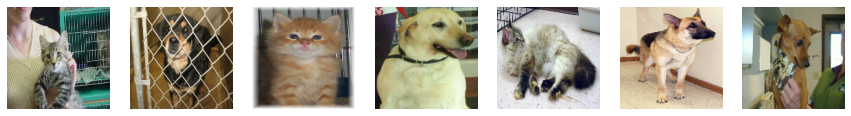

In [11]:
classNames = ['cat', 'dog']


i = 0

fig, ax = plt.subplots(1, 7, figsize=(15,15))
 
for image,label, t in train_ds.take(7):
 #  print(image.shape)
 #   predictedLabel = int(predictions[i] >= 0.5)
   # print(label)
   ax[i].axis('off')
   #ax[i].set_title(classNames[label.numpy()])
   ax[i].imshow(image)
    
   i += 1

In [12]:
# shuffle and create batches before training
batch_size = 128
train_batches = train_ds.shuffle(1024).batch(batch_size)
val_batches  = val_ds.shuffle(1024).batch(batch_size)
test_batches =  Test_data.shuffle(1024).batch(batch_size)

In [13]:
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import BatchNormalization

# from crowd_layer.crowd_layers import CrowdsClassification, MaskedMultiCrossEntropy
# from crowd_layer.crowd_aggregators import CrowdsCategoricalAggregator

def build_base_model():
    
  
    base_model = Sequential()
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
   
    base_model.add(BatchNormalization())
    base_model.add(Conv2D(32, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))
    

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))

    base_model.add(BatchNormalization())
    base_model.add(Conv2D(64, (3, 3)))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(MaxPooling2D(pool_size=(2, 2)))
   # base_model.add(Dropout(0.2))


    base_model.add(Flatten()) 
    base_model.add(BatchNormalization())
    base_model.add(Dense(128))
    base_model.add(Activation('relu'))
    base_model.add(BatchNormalization())
    base_model.add(Dropout(0.2))
    base_model.add(Dense(N_CLASSES))
    base_model.add(Activation('softmax'))

    base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm = 1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return base_model

In [14]:
N_CLASSES = 2
def one_hot(image, ytrue, label):
    one_hot_targets = tf.one_hot(tf.cast(label, tf.int32), N_CLASSES, axis = 1, dtype=tf.int32)
    return image, one_hot_targets


In [15]:

train_batches_MA = train_batches.map(one_hot)

In [16]:
val_batches_MA = val_batches.map(one_hot)

In [17]:

for i in train_batches_MA:
  print(i)
  break


(<tf.Tensor: shape=(128, 150, 150, 3), dtype=float32, numpy=
array([[[[8.69281068e-02, 9.73856226e-02, 7.05882385e-02],
         [9.01960805e-02, 9.41176489e-02, 7.05882385e-02],
         [9.24836621e-02, 8.85620937e-02, 6.89542517e-02],
         ...,
         [9.18630958e-01, 9.29088533e-01, 9.41016674e-01],
         [9.86274481e-01, 9.89705861e-01, 9.58823562e-01],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[8.62745121e-02, 9.80392173e-02, 7.05882385e-02],
         [9.01960805e-02, 9.41176489e-02, 7.05882385e-02],
         [9.26470608e-02, 9.00326818e-02, 6.97712451e-02],
         ...,
         [9.78268564e-01, 9.88726199e-01, 9.90033269e-01],
         [9.49999988e-01, 9.53921556e-01, 9.22549009e-01],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[8.92156884e-02, 9.50980410e-02, 7.05882385e-02],
         [9.31372568e-02, 9.11764726e-02, 7.05882385e-02],
         [9.59150344e-02, 8.61111134e-02, 6.65032715e-02],
         ...,
        

Epoch 1/40


2022-12-20 23:11:25.478191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


110/110 - 59s - loss: 0.7177 - val_loss: 0.6985
Epoch 2/40
110/110 - 10s - loss: 0.6983 - val_loss: 0.6971
Epoch 3/40
110/110 - 10s - loss: 0.6934 - val_loss: 0.6945
Epoch 4/40
110/110 - 10s - loss: 0.6896 - val_loss: 0.6936
Epoch 5/40
110/110 - 9s - loss: 0.6849 - val_loss: 0.6931
Epoch 6/40
110/110 - 10s - loss: 0.6798 - val_loss: 0.6903
Epoch 7/40
110/110 - 10s - loss: 0.6718 - val_loss: 0.6926
Epoch 8/40
110/110 - 10s - loss: 0.6597 - val_loss: 0.6839
Epoch 9/40
110/110 - 9s - loss: 0.6488 - val_loss: 0.6828
Epoch 10/40
110/110 - 9s - loss: 0.6453 - val_loss: 0.6707
Epoch 11/40
110/110 - 10s - loss: 0.6331 - val_loss: 0.6678
Epoch 12/40
110/110 - 9s - loss: 0.6199 - val_loss: 0.6617
Epoch 13/40
110/110 - 9s - loss: 0.6112 - val_loss: 0.6691
Epoch 14/40
110/110 - 10s - loss: 0.6227 - val_loss: 0.6675
Epoch 15/40
110/110 - 10s - loss: 0.6011 - val_loss: 0.6711
Epoch 16/40
110/110 - 10s - loss: 0.5907 - val_loss: 0.6739
Epoch 17/40
110/110 - 21s - loss: 0.5845 - val_loss: 0.6833
Epoch

2022-12-20 23:31:51.307125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 593 of 1024
2022-12-20 23:31:52.460547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 20s - loss: 0.6411 - val_loss: 0.6653
Epoch 11/40
110/110 - 9s - loss: 0.6312 - val_loss: 0.6605
Epoch 12/40
110/110 - 10s - loss: 0.6225 - val_loss: 0.6602
Epoch 13/40
110/110 - 9s - loss: 0.6182 - val_loss: 0.6600
Epoch 14/40
110/110 - 9s - loss: 0.6149 - val_loss: 0.6565
Epoch 15/40
110/110 - 8s - loss: 0.6075 - val_loss: 0.6607
Epoch 16/40
110/110 - 10s - loss: 0.6139 - val_loss: 0.6712
Epoch 17/40
110/110 - 9s - loss: 0.6037 - val_loss: 0.6653
Epoch 18/40
110/110 - 9s - loss: 0.6044 - val_loss: 0.6734
Epoch 19/40
110/110 - 8s - loss: 0.5854 - val_loss: 0.6849
Epoch 20/40
110/110 - 10s - loss: 0.5829 - val_loss: 0.6830
Epoch 21/40
110/110 - 9s - loss: 0.5726 - val_loss: 0.6966
Epoch 22/40
110/110 - 9s - loss: 0.5803 - val_loss: 0.6983
Epoch 23/40
110/110 - 9s - loss: 0.5666 - val_loss: 0.7120
Epoch 24/40
110/110 - 9s - loss: 0.5568 - val_loss: 0.7227
Epoch 25/40
110/110 - 9s - loss: 0.5468 - val_loss: 0.7253
Epoch 26/40
110/110 - 9s - loss: 0.5528 - val_loss: 0.7284
Epoch

2022-12-20 23:52:29.542406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-12-20 23:52:29.783808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 35s - loss: 0.7161 - val_loss: 0.7033
Epoch 2/40
110/110 - 23s - loss: 0.6972 - val_loss: 0.6938
Epoch 3/40
110/110 - 23s - loss: 0.6924 - val_loss: 0.6934
Epoch 4/40
110/110 - 13s - loss: 0.6890 - val_loss: 0.6924
Epoch 5/40
110/110 - 36s - loss: 0.6860 - val_loss: 0.6921
Epoch 6/40
110/110 - 13s - loss: 0.6773 - val_loss: 0.6897
Epoch 7/40
110/110 - 9s - loss: 0.6694 - val_loss: 0.6836
Epoch 8/40
110/110 - 9s - loss: 0.6580 - val_loss: 0.6734
Epoch 9/40
110/110 - 8s - loss: 0.6447 - val_loss: 0.6734
Epoch 10/40
110/110 - 9s - loss: 0.6389 - val_loss: 0.6637
Epoch 11/40
110/110 - 9s - loss: 0.6288 - val_loss: 0.6572
Epoch 12/40
110/110 - 10s - loss: 0.6227 - val_loss: 0.6572
Epoch 13/40
110/110 - 9s - loss: 0.6167 - val_loss: 0.6546
Epoch 14/40
110/110 - 9s - loss: 0.6070 - val_loss: 0.6596
Epoch 15/40
110/110 - 9s - loss: 0.6020 - val_loss: 0.6629
Epoch 16/40
110/110 - 10s - loss: 0.5990 - val_loss: 0.6700
Epoch 17/40
110/110 - 9s - loss: 0.5852 - val_loss: 0.6724
Epoch 18/

2022-12-21 00:01:36.321762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-12-21 00:01:40.120709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 93s - loss: 0.7179 - val_loss: 0.7077
Epoch 2/40
110/110 - 43s - loss: 0.6968 - val_loss: 0.6931
Epoch 3/40
110/110 - 9s - loss: 0.6922 - val_loss: 0.6939
Epoch 4/40
110/110 - 10s - loss: 0.6881 - val_loss: 0.6941
Epoch 5/40
110/110 - 9s - loss: 0.6810 - val_loss: 0.6948
Epoch 6/40
110/110 - 9s - loss: 0.6764 - val_loss: 0.6881
Epoch 7/40
110/110 - 9s - loss: 0.6671 - val_loss: 0.6859
Epoch 8/40
110/110 - 9s - loss: 0.6582 - val_loss: 0.6771
Epoch 9/40
110/110 - 9s - loss: 0.6439 - val_loss: 0.6733
Epoch 10/40
110/110 - 9s - loss: 0.6421 - val_loss: 0.6676
Epoch 11/40
110/110 - 9s - loss: 0.6277 - val_loss: 0.6676
Epoch 12/40
110/110 - 9s - loss: 0.6270 - val_loss: 0.6619
Epoch 13/40
110/110 - 9s - loss: 0.6101 - val_loss: 0.6635
Epoch 14/40
110/110 - 9s - loss: 0.6020 - val_loss: 0.6653
Epoch 15/40
110/110 - 9s - loss: 0.5952 - val_loss: 0.6711
Epoch 16/40
110/110 - 9s - loss: 0.6014 - val_loss: 0.6775
Epoch 17/40
110/110 - 9s - loss: 0.6096 - val_loss: 0.6833
Epoch 18/40
11

2022-12-21 00:10:20.520865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-12-21 00:10:24.096488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 94s - loss: 0.7198 - val_loss: 0.7047
Epoch 2/40
110/110 - 40s - loss: 0.6975 - val_loss: 0.6943
Epoch 3/40
110/110 - 9s - loss: 0.6935 - val_loss: 0.6941
Epoch 4/40
110/110 - 8s - loss: 0.6907 - val_loss: 0.6938
Epoch 5/40
110/110 - 10s - loss: 0.6857 - val_loss: 0.6898
Epoch 6/40
110/110 - 9s - loss: 0.6815 - val_loss: 0.6870
Epoch 7/40
110/110 - 9s - loss: 0.6745 - val_loss: 0.6855
Epoch 8/40
110/110 - 9s - loss: 0.6627 - val_loss: 0.6746
Epoch 9/40
110/110 - 10s - loss: 0.6520 - val_loss: 0.6675
Epoch 10/40
110/110 - 9s - loss: 0.6405 - val_loss: 0.6623
Epoch 11/40
110/110 - 9s - loss: 0.6350 - val_loss: 0.6640
Epoch 12/40
110/110 - 9s - loss: 0.6258 - val_loss: 0.6568
Epoch 13/40
110/110 - 10s - loss: 0.6247 - val_loss: 0.6618
Epoch 14/40
110/110 - 8s - loss: 0.6112 - val_loss: 0.6562
Epoch 15/40
110/110 - 9s - loss: 0.6247 - val_loss: 0.6621
Epoch 16/40
110/110 - 9s - loss: 0.6076 - val_loss: 0.6636
Epoch 17/40
110/110 - 9s - loss: 0.5956 - val_loss: 0.6679
Epoch 18/40


2022-12-21 00:19:00.575405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-12-21 00:19:04.024621: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 92s - loss: 0.7193 - val_loss: 0.6955
Epoch 2/40
110/110 - 37s - loss: 0.6980 - val_loss: 0.6958
Epoch 3/40
110/110 - 9s - loss: 0.6923 - val_loss: 0.6953
Epoch 4/40
110/110 - 10s - loss: 0.6891 - val_loss: 0.6927
Epoch 5/40
110/110 - 10s - loss: 0.6852 - val_loss: 0.6923
Epoch 6/40
110/110 - 9s - loss: 0.6760 - val_loss: 0.6873
Epoch 7/40
110/110 - 9s - loss: 0.6691 - val_loss: 0.6812
Epoch 8/40
110/110 - 9s - loss: 0.6658 - val_loss: 0.6747
Epoch 9/40
110/110 - 9s - loss: 0.6482 - val_loss: 0.6679
Epoch 10/40
110/110 - 9s - loss: 0.6361 - val_loss: 0.6675
Epoch 11/40
110/110 - 9s - loss: 0.6350 - val_loss: 0.6627
Epoch 12/40
110/110 - 10s - loss: 0.6265 - val_loss: 0.6545
Epoch 13/40
110/110 - 9s - loss: 0.6139 - val_loss: 0.6545
Epoch 14/40
110/110 - 9s - loss: 0.6054 - val_loss: 0.6574
Epoch 15/40
110/110 - 9s - loss: 0.6110 - val_loss: 0.6611
Epoch 16/40
110/110 - 10s - loss: 0.5940 - val_loss: 0.6666
Epoch 17/40
110/110 - 9s - loss: 0.5868 - val_loss: 0.6766
Epoch 18/40

2022-12-21 00:27:41.172761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2022-12-21 00:27:45.062069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


110/110 - 93s - loss: 0.7222 - val_loss: 0.6984
Epoch 2/40
110/110 - 40s - loss: 0.7000 - val_loss: 0.6947
Epoch 3/40
110/110 - 10s - loss: 0.6950 - val_loss: 0.6941
Epoch 4/40
110/110 - 9s - loss: 0.6903 - val_loss: 0.6929
Epoch 5/40
110/110 - 9s - loss: 0.6865 - val_loss: 0.6913
Epoch 6/40
110/110 - 9s - loss: 0.6782 - val_loss: 0.6903
Epoch 7/40
110/110 - 9s - loss: 0.6685 - val_loss: 0.6812
Epoch 8/40
110/110 - 9s - loss: 0.6569 - val_loss: 0.6769
Epoch 9/40
110/110 - 9s - loss: 0.6460 - val_loss: 0.6684
Epoch 10/40
110/110 - 9s - loss: 0.6386 - val_loss: 0.6632
Epoch 11/40
110/110 - 9s - loss: 0.6336 - val_loss: 0.6583
Epoch 12/40
110/110 - 10s - loss: 0.6228 - val_loss: 0.6572
Epoch 13/40
110/110 - 9s - loss: 0.6152 - val_loss: 0.6601
Epoch 14/40
110/110 - 10s - loss: 0.6064 - val_loss: 0.6613
Epoch 15/40
110/110 - 9s - loss: 0.6014 - val_loss: 0.6655
Epoch 16/40
110/110 - 9s - loss: 0.5910 - val_loss: 0.6737
Epoch 17/40
110/110 - 9s - loss: 0.5834 - val_loss: 0.6857
Epoch 18/40


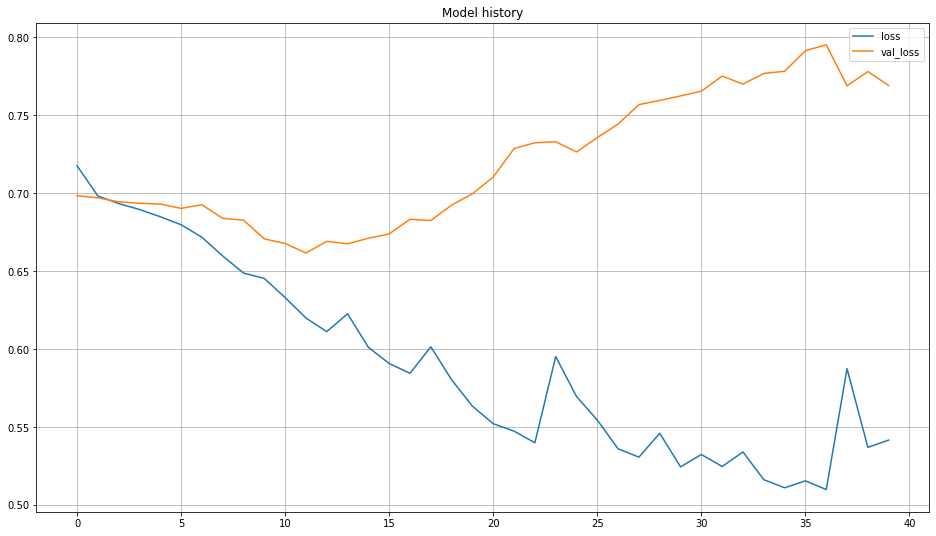

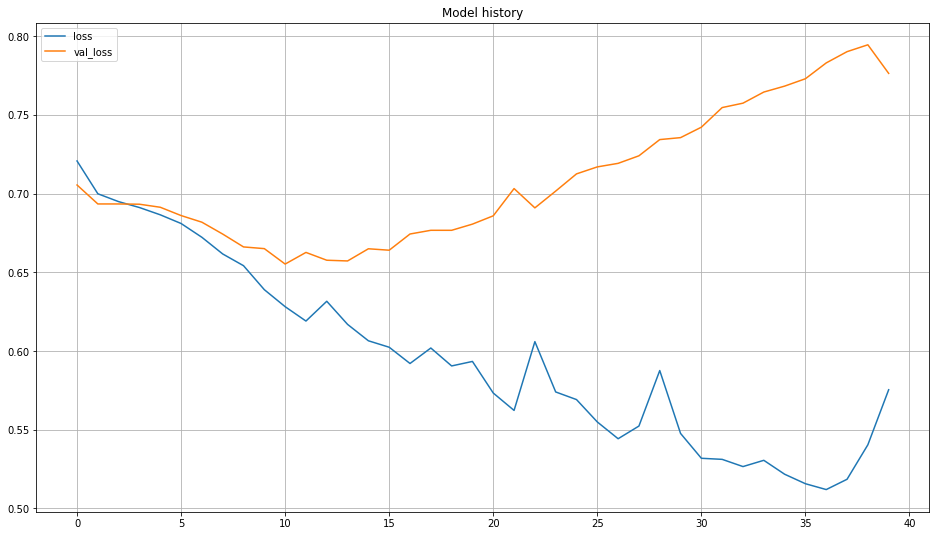

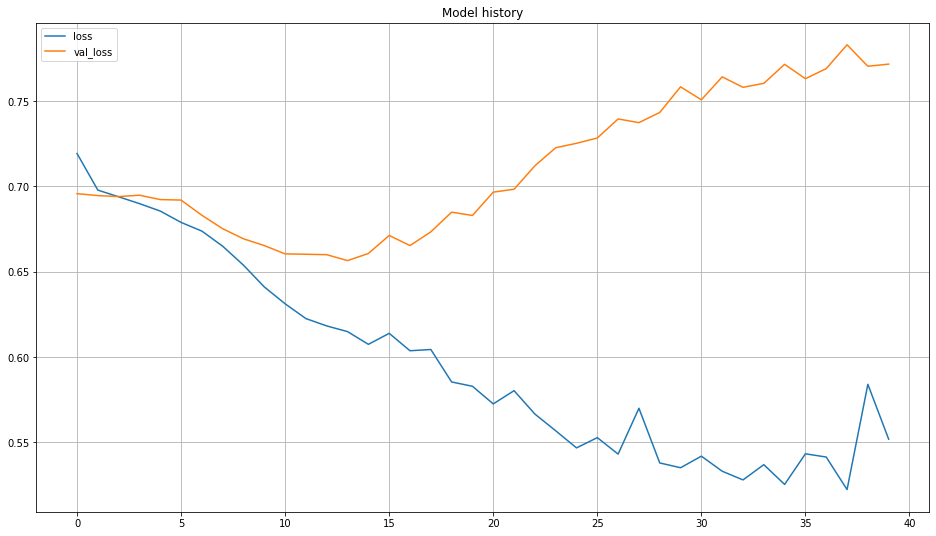

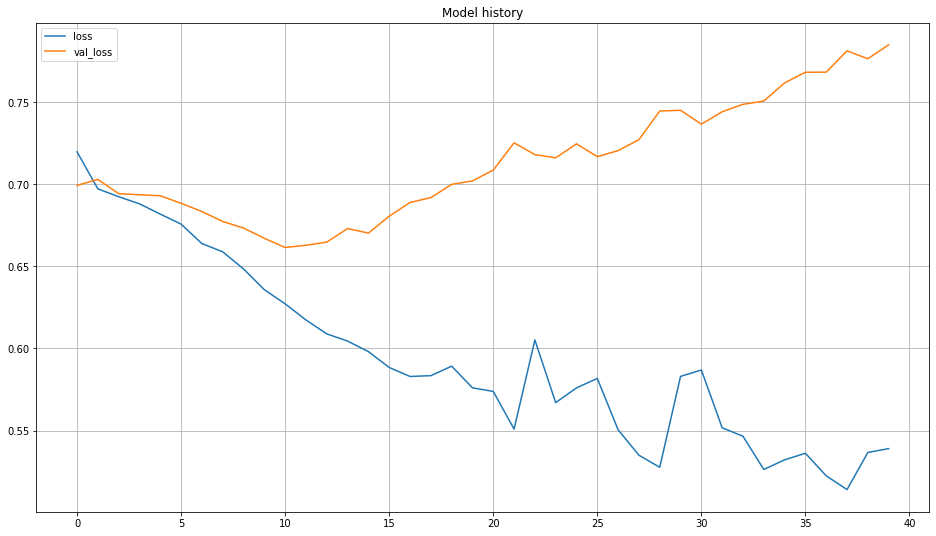

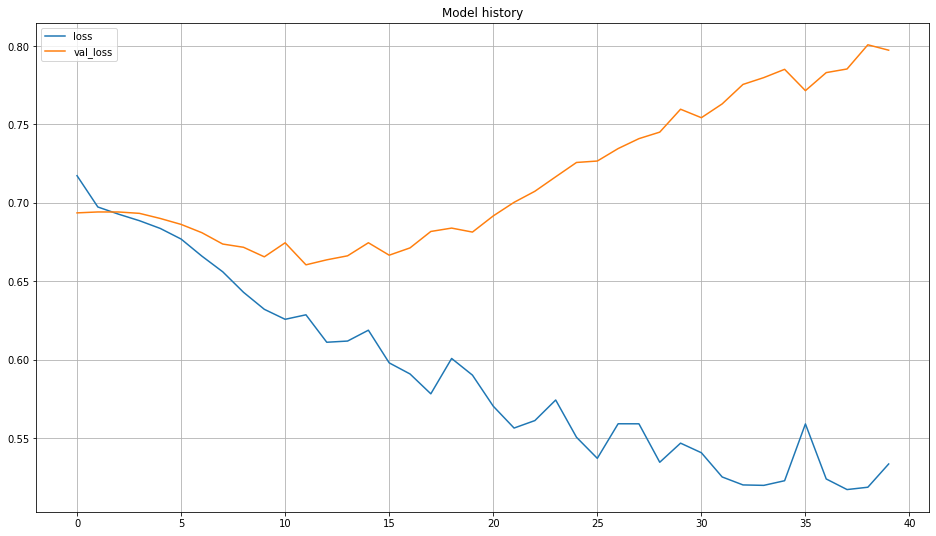

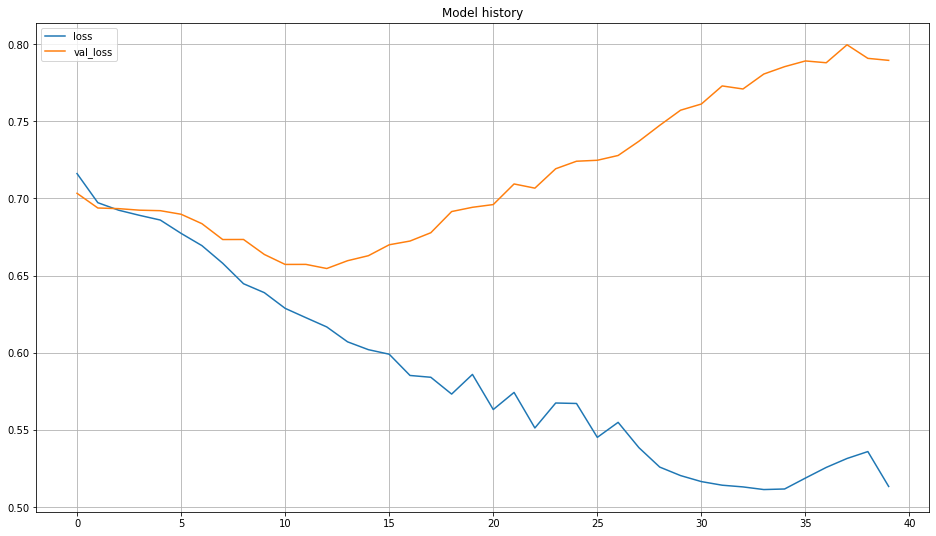

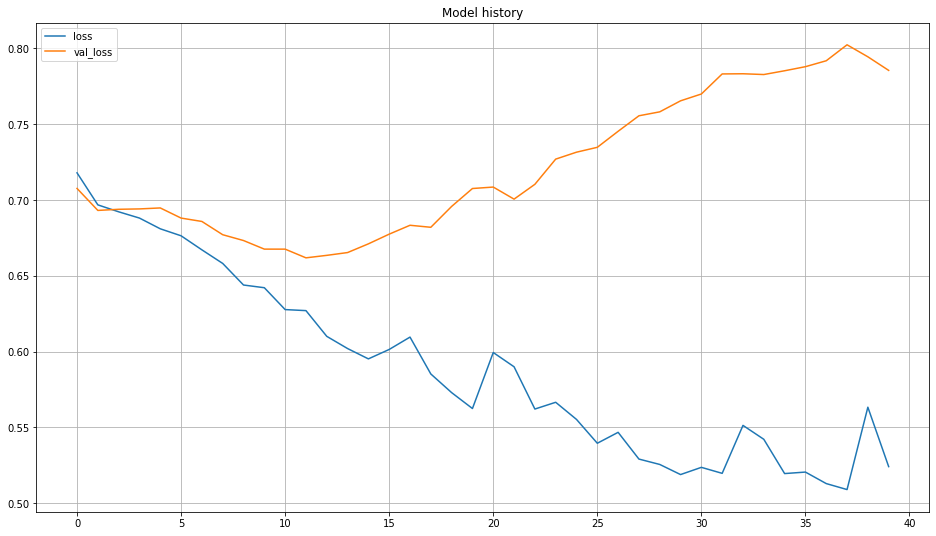

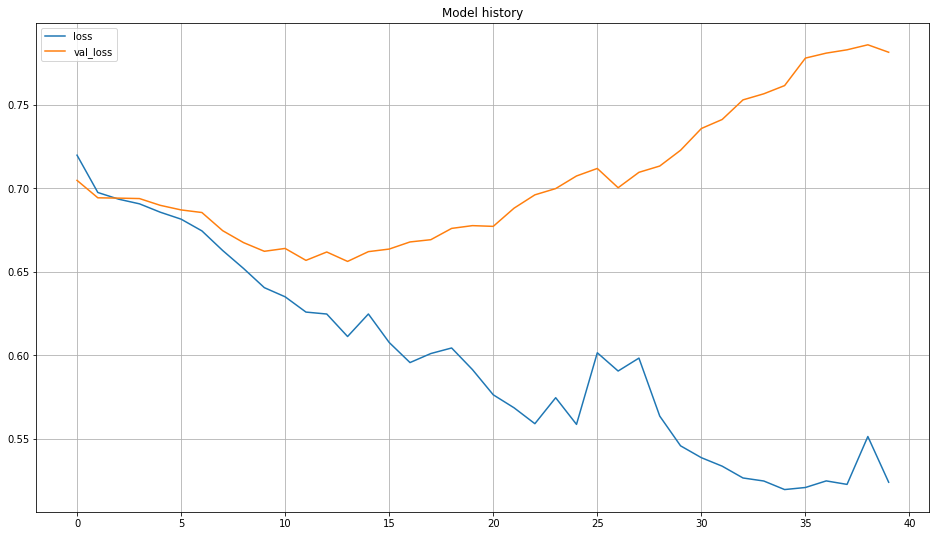

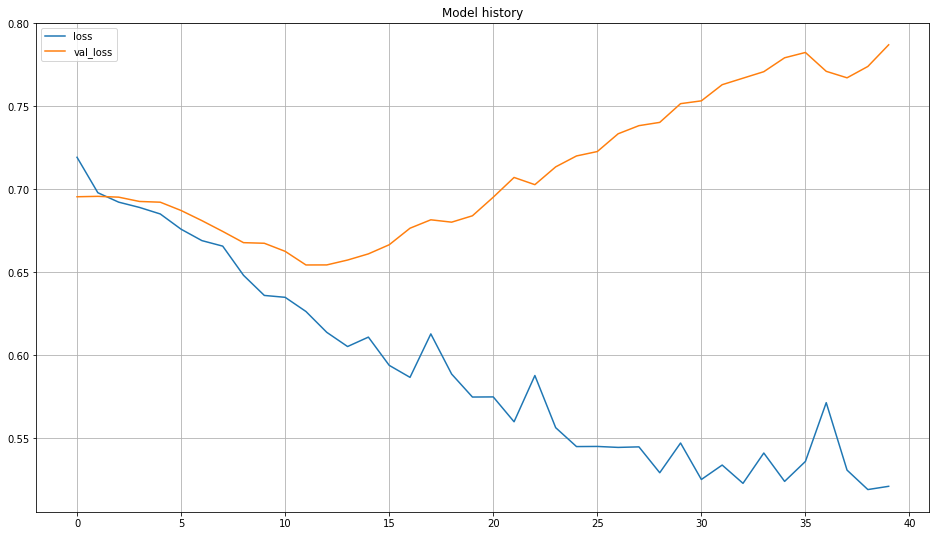

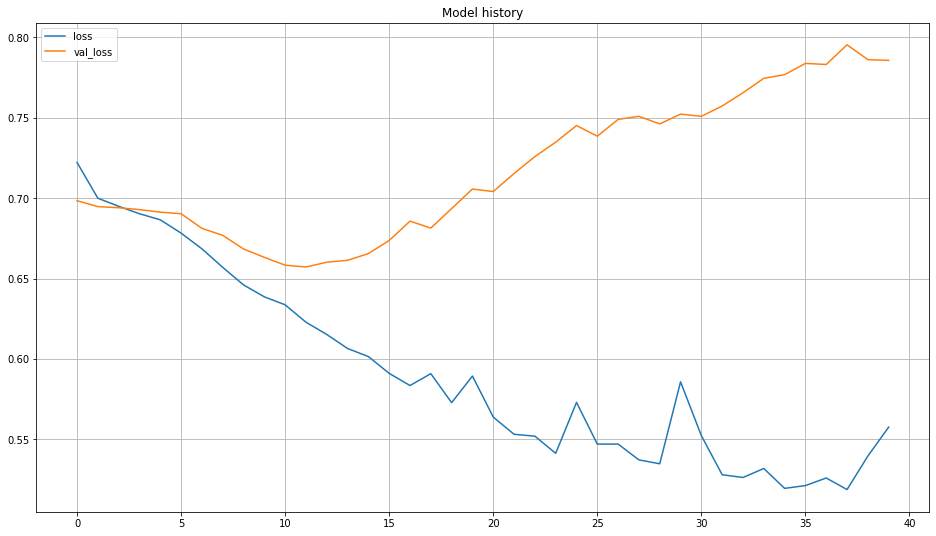

In [18]:
NUM_RUNS = 10
N_EPOCHS = 40
N_ANNOT = 5
K= 2
AUC= np.zeros(NUM_RUNS)
res = np.zeros(NUM_RUNS)


for i in range(NUM_RUNS):
 
    model = build_base_model()

    # add crowds layer on top of the base model
    model.add(CrowdsClassification(N_CLASSES, N_ANNOT, conn_type="MW"))


    # instantiate specialized masked loss to handle missing answers
    loss = MaskedMultiCrossEntropy().loss

    # compile model with masked loss and train
    model.compile(optimizer='adam', loss=loss)
    trainHistory =  model.fit(train_batches_MA,validation_data=val_batches_MA, epochs=N_EPOCHS, shuffle=True, verbose=2)

    # Create the history figure
    plt.figure(figsize=(16,9))
    for g in  trainHistory.history:
        plt.plot( trainHistory.history[g],label=g)
    plt.title('Model history')
    plt.legend()
    plt.grid()
    
    model.pop() 
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
    val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
    for x_batch_val, y_batch_val in test_batches:
        val_logits = model(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_acc = val_acc.numpy()
    print("Validation acc: %.4f" % (float(val_acc),))
    res[i] = val_acc
    
    #AUC =======================
    val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
    for x_batch_val, y_batch_val in test_batches:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation AUC: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    #===================================================



In [19]:
res

array([0.7138865 , 0.71453136, 0.71474636, 0.71216679, 0.70507306,
       0.72141016, 0.69969904, 0.71474636, 0.71324164, 0.70528805])

In [20]:
AUC

array([0.71339607, 0.7139349 , 0.71434981, 0.71165013, 0.70524687,
       0.72142017, 0.69899893, 0.71421373, 0.7131294 , 0.70457304])

In [21]:
print('Average Accuracy: ', np.round(res.mean(),4)*100) 
print('STD Accuracy: ', np.round(np.std(res),4)*100) 

Average Accuracy:  71.15
STD Accuracy:  0.6


In [22]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)


Average Accuracy:  71.11
Average std:  0.61
